<img src="https://www.northumbria.ac.uk/-/media/40f0efdb3a6745fda5b0d982d53b8cd9.ashx" alt="Northumbria University"/>

---

 
### KF7029 MSc Computer Science and Digital Technologies Project

Dissertation project title:
# How Machine Learning (ML) can improve Business?

---
**Student ID:** W19052374

**Student Name:** Rohit Karanam

---

**Supervisor Name	:** 

**Second Marker Name	:** 

---

# CH-1 Configration

##  Dataset
Brazilian E-Commerce data
https://www.kaggle.com/code/santiagorcastro/3-insights-on-olist-dataset-brazilian-ecommerce/data


## Python packages

In [1]:
## install
#!pip install numpy
#!pip install xgboost

In [2]:
## import
import pandas as pd
import numpy as np

# GRAPH RELATED LIBRARY
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Error and warnings
import warnings
warnings.filterwarnings('ignore')

# data compose and decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

# ML Model and layer
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import *
from keras.layers import Dense

# CH-2 Dataset 

In [3]:
# file path
lc_root="./Brazilian E-Commerce/"
lc_review="olist_order_reviews_dataset.csv"
lc_orders="olist_orders_dataset.csv"
lc_order_products="olist_order_items_dataset.csv"
lc_products="olist_products_dataset.csv"
lc_customers="olist_customers_dataset.csv"
lc_geolocation="olist_geolocation_dataset.csv"

In [4]:
def load_dataset(file, columns):
    path= lc_root + file
    data=pd.read_csv(path,names=columns, header=0)
    print(f'Total rows:{data.shape[0]} and columns:{data.shape[1]} for {file}')   
    return data

In [5]:
dt_review=load_dataset(
    lc_review,
    ["review_id","order_id","review_score","review_comment_title","review_comment_message","review_creation_date","review_answer_timestamp"]
)

dt_orders=load_dataset(
    lc_orders,
    ["order_id","customer_id","order_status","order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]
)

dt_order_products=load_dataset(
    lc_order_products,
    ["order_id","order_item_id","product_id","seller_id","shipping_limit_date","price","freight_value"]
)

dt_products=load_dataset(
    lc_products,
    ["product_id","product_category_name","product_name_lenght","product_description_lenght","product_photos_qty","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]
)
lc_customers

dt_customers=load_dataset(
    lc_customers,
    ["customer_id","customer_unique_id","customer_zip_code_prefix","customer_city","customer_state"]
)
dt_geolocation=load_dataset(
    lc_geolocation,
    ["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng","geolocation_city","geolocation_state"]
)


Total rows:99224 and columns:7 for olist_order_reviews_dataset.csv
Total rows:99441 and columns:8 for olist_orders_dataset.csv
Total rows:112650 and columns:7 for olist_order_items_dataset.csv
Total rows:32951 and columns:9 for olist_products_dataset.csv
Total rows:99441 and columns:5 for olist_customers_dataset.csv
Total rows:1000163 and columns:5 for olist_geolocation_dataset.csv


# CH-3 Pre-processing 

In [6]:
# Remove unused columns
dt_orders = dt_orders[['order_id','customer_id','order_purchase_timestamp']]
dt_order_products = dt_order_products[['order_id','order_item_id','product_id','price']]
dt_products = dt_products[["product_id","product_category_name"]]
dt_review = dt_review[["review_id","order_id","review_score","review_comment_title","review_comment_message","review_creation_date"]]
dt_customers = dt_customers[["customer_id","customer_city","customer_state","customer_zip_code_prefix"]]
dt_geolocation = dt_geolocation[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng","geolocation_city","geolocation_state"]]

In [7]:
# Change column type
dt_orders['order_id']=dt_orders['order_id'].astype(str)
dt_orders['customer_id']=dt_orders['customer_id'].astype(str)
dt_order_products['order_id']=dt_order_products['order_id'].astype(str)
dt_order_products['product_id']=dt_order_products['product_id'].astype(str)
dt_products['product_id']=dt_products['product_id'].astype(str)
dt_review['order_id']=dt_order_products['order_id'].astype(str)
dt_customers['customer_id']=dt_customers['customer_id'].astype(str)

In [8]:
# rename column
dt_customers = dt_customers.rename(columns={'customer_zip_code_prefix':'zip_code'})
dt_geolocation = dt_geolocation.rename(columns={'geolocation_zip_code_prefix':'zip_code'})

In [9]:
# merge datasets
dt_main=pd.merge(dt_orders, dt_order_products, on = 'order_id')
dt_main=pd.merge(dt_main, dt_review, on = 'order_id')
dt_main=pd.merge(dt_main, dt_products, on = 'product_id')
dt_main=pd.merge(dt_main, dt_customers, on = 'customer_id')
dt_main=pd.merge(dt_main, dt_geolocation, on = 'zip_code')

In [10]:
# count number of duplicate rows
# Remove duplicate entires
print('Total duplicate records:',dt_main.duplicated().sum())
dt_main.drop_duplicates(inplace=True)

Total duplicate records: 6770723


In [11]:
dt_main['order_purchase_timestamp'].str[0:7]

0           2018-07
1           2018-07
2           2018-07
3           2018-07
4           2018-07
             ...   
21308769    2017-12
21308770    2017-12
21308771    2017-12
21308772    2017-12
21308773    2017-12
Name: order_purchase_timestamp, Length: 14538051, dtype: object

In [12]:
# Extract Year-Month from timestamp
dt_main['month']=dt_main['order_purchase_timestamp'].str[0:7]
dt_main['Invoice_date']=dt_main['order_purchase_timestamp'].str[0:7]

In [13]:
# Convert data type
dt_main['order_purchase_timestamp']=pd.to_datetime(dt_main['order_purchase_timestamp'])
dt_main['geolocation_lat'] = dt_main['geolocation_lat'].astype(np.float64)
dt_main['geolocation_lng'] = dt_main['geolocation_lng'].astype(np.float64)

In [14]:
dt_main['YY'] = dt_main['order_purchase_timestamp'].dt.year 
dt_main['MM'] = dt_main['order_purchase_timestamp'].dt.month 
dt_main['DD'] = dt_main['order_purchase_timestamp'].dt.day 
dt_main['Hour'] = dt_main['order_purchase_timestamp'].dt.hour 
dt_main['Minute'] = dt_main['order_purchase_timestamp'].dt.minute 

In [15]:
dt_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14538051 entries, 0 to 21308773
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   order_id                  object        
 1   customer_id               object        
 2   order_purchase_timestamp  datetime64[ns]
 3   order_item_id             int64         
 4   product_id                object        
 5   price                     float64       
 6   review_id                 object        
 7   review_score              int64         
 8   review_comment_title      object        
 9   review_comment_message    object        
 10  review_creation_date      object        
 11  product_category_name     object        
 12  customer_city             object        
 13  customer_state            object        
 14  zip_code                  int64         
 15  geolocation_lat           float64       
 16  geolocation_lng           float64       
 17  geoloc

In [16]:
dt_main.head()

,order_id,customer_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,review_comment_title,review_comment_message,...,geolocation_lng,geolocation_city,geolocation_state,month,Invoice_date,YY,MM,DD,Hour,Minute
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.7,ee003f7cabb1176c9825101bae3fe4f2,5,NaN,NaN,...,-44.988369,barreiras,BA,2018-07,2018-07,2018,7,24,20,41
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.7,ee003f7cabb1176c9825101bae3fe4f2,5,NaN,NaN,...,-45.016167,barreiras,BA,2018-07,2018-07,2018,7,24,20,41
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.7,ee003f7cabb1176c9825101bae3fe4f2,5,NaN,NaN,...,-45.008985,barreiras,BA,2018-07,2018-07,2018,7,24,20,41
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.7,ee003f7cabb1176c9825101bae3fe4f2,5,NaN,NaN,...,-45.016161,barreiras,BA,2018-07,2018-07,2018,7,24,20,41
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.7,ee003f7cabb1176c9825101bae3fe4f2,5,NaN,NaN,...,-45.008162,barreiras,BA,2018-07,2018-07,2018,7,24,20,41


In [17]:
len(dt_main["product_category_name"].unique())

74

# CH-4 Machine Learning (ML) analysis 

## 1) Sales Forecasting

In [40]:
def split_dataset(mtrain, mtest):
    
    # APPLY SCALER
    s = MinMaxScaler(feature_range=(-1, 1))
    s = s.fit(mtrain)

    # RE-SHAPE
    mtrain = mtrain.reshape(mtrain.shape[0], mtrain.shape[1])
    mtest = mtest.reshape(mtest.shape[0], mtest.shape[1])
    
    # TRANFORM
    s_train = s.transform(mtrain)         
    s_test = s.transform(mtest)

    # RAVEL
    X1, Y1 = s_train[:, 1:], s_train[:, 0:1].ravel()
    X2, Y2 = s_test[:, 1:], s_test[:, 0:1].ravel()

    # RETURN
    return X1, Y1, X2, Y2, s

In [41]:
# COPY DATA FROM MAIN DATASET
data_sales=dt_main.copy()

# FIND TOTAL MONTHLY SALES
data_sales=data_sales.groupby('Invoice_date')["price"].sum().reset_index()

# TO MILLION SALES
data_sales["price"]=data_sales["price"]/100000

# GET DIFFERENCES
data_sales['difference'] = data_sales["price"].diff()
data_sales = data_sales.dropna()            


# CREATE SUPERVISED DATA
supervised_sales = data_sales.copy()
for i in range(1,13):
    col = 'lag_' + str(i)
    supervised_sales[col] = supervised_sales['difference'].shift(i)


# REMOVE NOT USED VALUES
supervised_sales = supervised_sales.drop(["price", 'Invoice_date'], axis=1)
supervised_sales = supervised_sales.dropna().reset_index(drop=True)

# Create useful dataset
x, y = supervised_sales[0:-3].values, supervised_sales[-12:].values
x1, y1, x2, y2, scaler_object = split_dataset(x, y)

In [42]:
data_sales

,Invoice_date,price,difference
1,2016-10,67.123964,65.798120
2,2016-12,0.016241,-67.107723
3,2017-01,144.864145,144.847904
4,2017-02,250.427523,105.563378
5,2017-03,397.801853,147.374330
6,2017-04,412.691493,14.889640
7,2017-05,569.533082,156.841589
8,2017-06,472.755412,-96.777670
9,2017-07,620.830155,148.074743
10,2017-08,642.469295,21.639140


In [43]:
# FORECASTED SALES
model_forecast = pd.DataFrame({'Invoice_date':[]})

In [44]:
def reshape_data(model_forecasted, axisX, scaler_obj):    
    
    # RE-SHAPE
    model_forecasted = model_forecasted.reshape(model_forecasted.shape[0], 1, 1)
    axisX = axisX.reshape(axisX.shape[0], 1, axisX.shape[1])
    data = []
    
    # INVERSE DATA
    for index in range(0, len(model_forecasted)):
        data.append(np.concatenate([model_forecasted[index], axisX[index]],axis=1))

    # RESHAPE
    data = np.array(data)
    data = data.reshape(data.shape[0],data.shape[2])

    #TRANSFORM
    test_inverted = scaler_obj.inverse_transform(data)

    # RETURN
    return test_inverted

In [45]:
def model_cal_errors(model_forecast, algo):        
    filter=-11
    errR2 = r2_score(data_sales["price"][-11:], model_forecast[f"pred_price"][filter:])
    errMSE = np.sqrt(mean_squared_error(data_sales["price"][-11:], model_forecast[f"pred_price"][filter:]))   
    errMAE = mean_absolute_error(data_sales["price"][filter:], model_forecast[f"pred_price"][filter:])
    print (f"Mean squared error:{errMSE} \nMean absolute error:{errMAE}, \nR2_score: {errR2}")
    return errMSE, errMAE, errR2

In [46]:
def forecastSales(val, data):
    
    # extract values
    dates = list(data[-13:].Invoice_date)
    act = list(data[-13:]["price"])
    forecasted_sales = []
    # perform 
    for index in range(0, len(val)):
        # new frame
        row = {}
        
        # set frame values
        row[f"pred_price"] = int(val[index][0] +act[index])
        row['Invoice_date'] = dates[index+1]
        row['Invoice_date']=row['Invoice_date'].replace("2018", "2019")
        row['Invoice_date']=row['Invoice_date'].replace("2017", "2018")

        # append frame in predicted list
        forecasted_sales.append(row)

    # return predicted values
    return pd.DataFrame(forecasted_sales)

In [47]:
def forecast_sales(algo):
        
    d=20
    lr=0.001
    obj='reg:squarederror'
    n=100
    
    print (f"Forecasting using {algo} ")
   
    mod =LinearRegression()

    if algo=='Linear Regression':
        mod = LinearRegression()
    elif algo=='Random Forest':
        mod =RandomForestRegressor(max_depth=d)
    elif algo=='XGBoost':
        mod =XGBRegressor(learning_rate=lr,n_estimators=n,objective=obj)

    # FIT DATA
    mod.fit(x1, y1)

    # FORECAST SALES
    model_forecast = mod.predict(x2)
    reshaped = reshape_data(model_forecast, x2, scaler_object)
    model_forecast = forecastSales(reshaped, data_sales)
    
    # RETURN FORECAST
    return model_forecast

In [48]:
def model_graph(model_forecast,algo):
    # SHOW GRAPH
    fig, ax = plt.subplots()
    ax.tick_params(axis='x', rotation=80)   
    sns.lineplot(data=data_sales,y=data_sales["price"], x=data_sales.Invoice_date, ax=ax, markers=True,label=f"actual price")
    sns.lineplot(data=model_forecast,y=model_forecast[f"pred_price"], x=model_forecast.Invoice_date, ax=ax,markers=True,label= f"forecasted price")
    ax.set(xlabel="Month",ylabel="Sales ($) millions",title=f"Sales forecast using {algo}")
    ax.legend()

### Random Foreset 

In [49]:
# RUN FORECASTING
model_forecast= forecast_sales('XGBoost')

Forecasting using XGBoost 


In [50]:
model_forecast

,pred_price,Invoice_date
0,1043,2018-10
1,1044,2018-11
2,1623,2018-12
3,1142,2019-01
4,1409,2019-02
5,1278,2019-03
6,1386,2019-04
7,1380,2019-05
8,1498,2019-06
9,1287,2019-07


Mean squared error:502.5945569630259 
Mean absolute error:384.9049825636364, 
R2_score: -1.3137072344247183


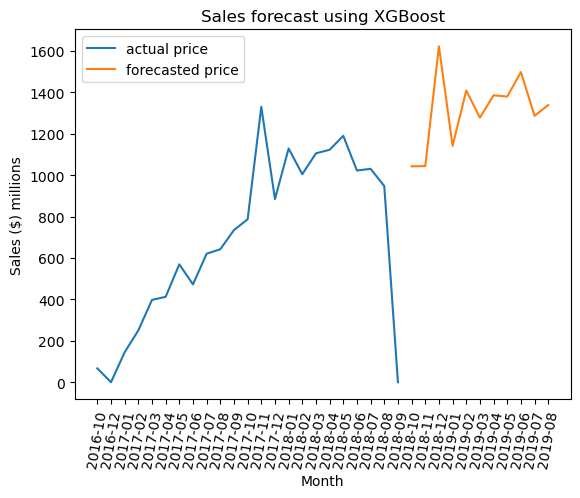

In [51]:

# GET MODEL ERRORS
model_cal_errors(model_forecast,'XGBoost')

# DISPLAY GRAPH
model_graph(model_forecast,'XGBoost')

## Random Forest

In [52]:
# RUN FORECASTING
model_forecast= forecast_sales('Random Forest')

Forecasting using Random Forest 


In [53]:
model_forecast

,pred_price,Invoice_date
0,1096,2018-10
1,482,2018-11
2,1598,2018-12
3,761,2019-01
4,1294,2019-02
5,953,2019-03
6,1219,2019-04
7,951,2019-05
8,1484,2019-06
9,898,2019-07


Mean squared error:474.0831409581948 
Mean absolute error:328.57818436363635, 
R2_score: -1.0586469143172317


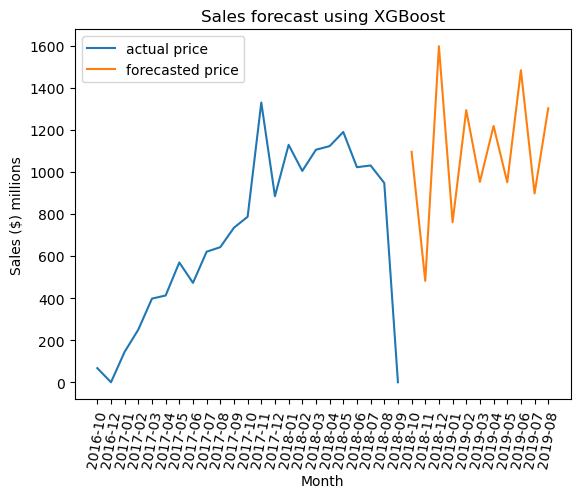

In [54]:

# GET MODEL ERRORS
model_cal_errors(model_forecast,'XGBoost')

# DISPLAY GRAPH
model_graph(model_forecast,'XGBoost')

## Linear Regression

In [58]:
# RUN FORECASTING
model_forecast= forecast_sales('Linear Regression')

Forecasting using Linear Regression 


In [59]:
model_forecast

,pred_price,Invoice_date
0,1278,2018-10
1,341,2018-11
2,1574,2018-12
3,760,2019-01
4,1229,2019-02
5,1022,2019-03
6,1173,2019-04
7,955,2019-05
8,2727,2019-06
9,544,2019-07


Mean squared error:626.4387897792398 
Mean absolute error:411.4345999818182, 
R2_score: -2.594430795280946


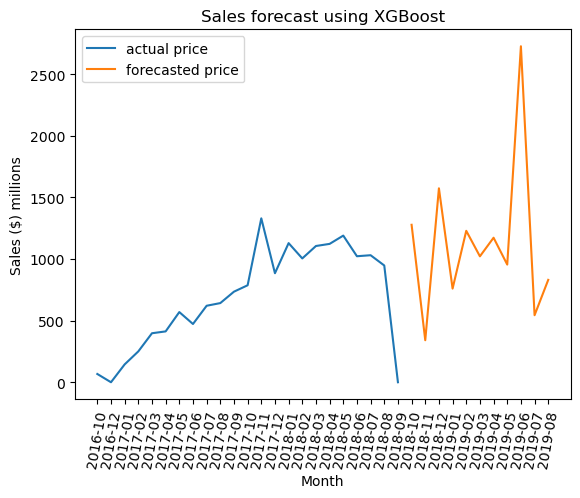

In [60]:

# GET MODEL ERRORS
model_cal_errors(model_forecast,'XGBoost')

# DISPLAY GRAPH
model_graph(model_forecast,'XGBoost')

## 2) Analyze current Business sales

### Question 1: Which is the best month for sales?

In [61]:
def disp_graph(data, f1,f2,title):
    plt.bar(data[f1],data[f2])
    plt.ylabel('sales ($)')
    plt.xticks(data[f1])
    plt.xlabel(yy)
    plt.title(title,fontname='Arial',fontweight='bold',fontsize=11)    
    plt.tick_params(axis='x', rotation=80)
    plt.tick_params(axis='y', rotation=80)
    plt.show()

     month       price
8  2018-09    0.002320
7  2018-08   94.764994
1  2018-02  100.498893
5  2018-06  102.269993
6  2018-07  103.097066
2  2018-03  110.582919
3  2018-04  112.297173
0  2018-01  112.915657
4  2018-05  119.021029


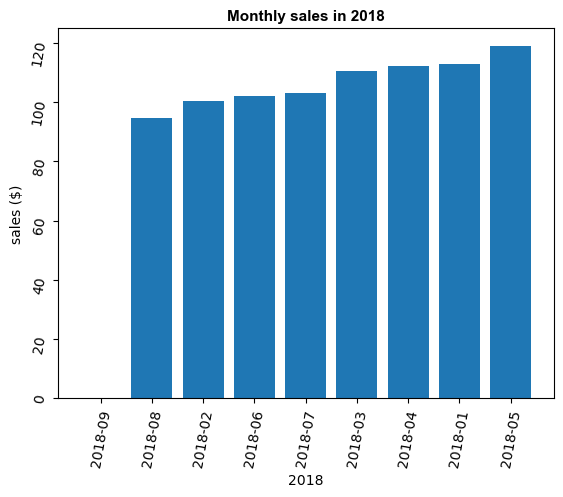

      month       price
0   2017-01   14.486415
1   2017-02   25.042752
2   2017-03   39.780185
3   2017-04   41.269149
5   2017-06   47.275541
4   2017-05   56.953308
6   2017-07   62.083016
7   2017-08   64.246929
8   2017-09   73.513745
9   2017-10   78.707510
11  2017-12   88.489209
10  2017-11  133.034733


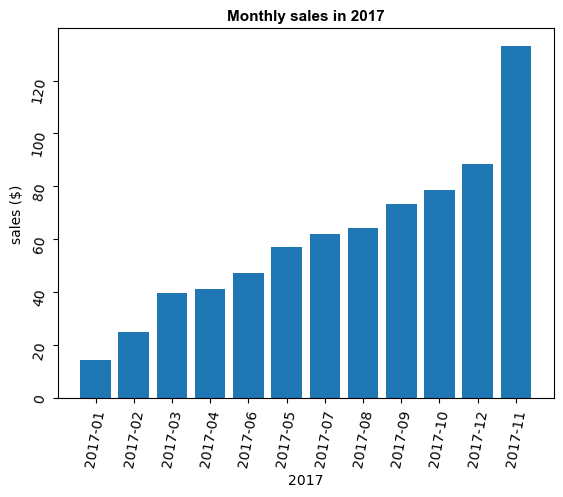

     month     price
2  2016-12  0.001624
0  2016-09  0.132584
1  2016-10  6.712396


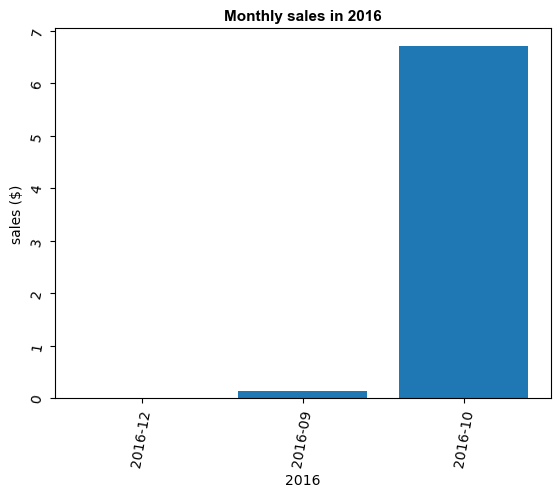

In [65]:
for yy in dt_main['YY'].unique():
    # etract monthly sales
    dataPart1=dt_main[dt_main['YY']==yy]    
    
    # calcualte sales revenue
    dataPart1=dataPart1.groupby(dataPart1['month']).agg({'price': 'sum'}).reset_index()    
    dataPart1=dataPart1.sort_values(by=['price'])
    
    # To million
    dataPart1['price']=dataPart1['price']/1000000
    
    # Print sales
    print(dataPart1)
    
    # show graph
    disp_graph(dataPart1,"month","price",f"Monthly sales in {yy}")

### Question 2: Highest sales city

              customer_city      price
2374         rio de janeiro  70.509779
2708              sao paulo  62.008624
345          belo horizonte  38.527291
1853                niteroi  18.101586
865                curitiba  14.641222
2569                 santos  12.901826
2218           porto alegre  12.199163
537                campinas  10.289116
2975             uberlandia   9.897319
2445               salvador   9.548299
1022          florianopolis   8.494958
2540            santo andre   7.262249
3070             vila velha   7.222040
3057                 vicosa   7.060340
1520                jundiai   7.037786
2578  sao bernardo do campo   6.680452
1153              guarulhos   6.625423
1272               ipatinga   6.600525
901             divinopolis   6.215036
424                brasilia   5.892311


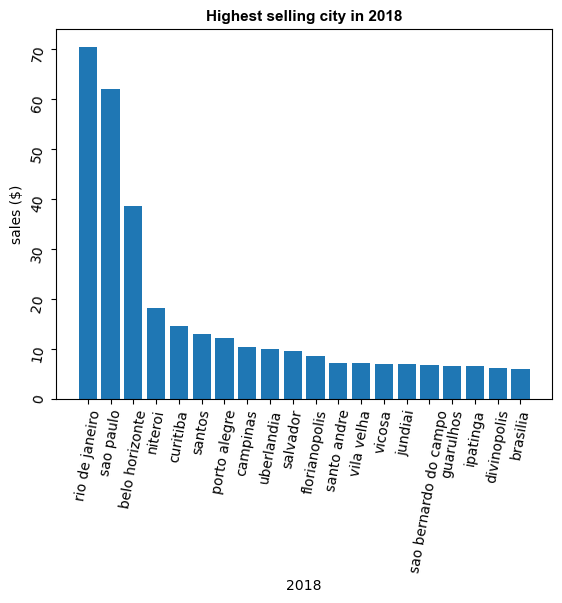

              customer_city      price
2390         rio de janeiro  78.795254
2726              sao paulo  42.781255
336          belo horizonte  25.676921
900             divinopolis  25.615303
1880                niteroi  13.162866
2258           porto alegre  11.316246
2990             uberlandia  10.514389
867                curitiba   9.857130
1819          montes claros   8.985066
2596                 santos   8.653807
527                campinas   7.932704
2467               salvador   7.768782
188                araruama   7.748327
1290               ipatinga   5.939125
2570            santo andre   5.778123
1026          florianopolis   5.592256
2607  sao bernardo do campo   5.114290
1547                jundiai   5.099786
1598                 lavras   4.831236
3088                vitoria   4.444296


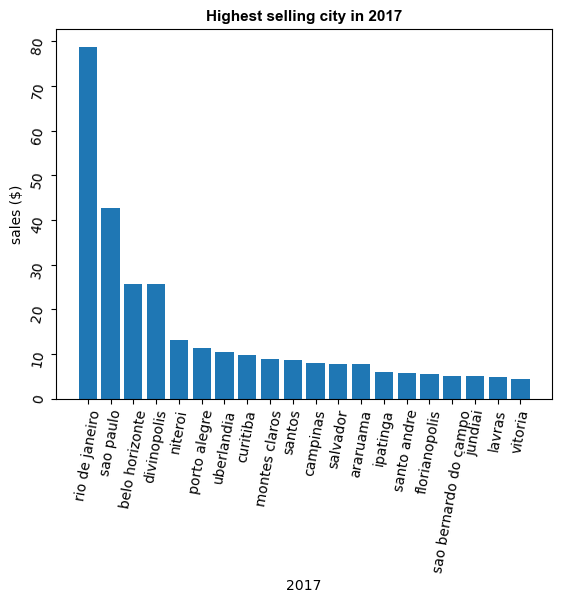

                 customer_city     price
111             rio de janeiro  0.745791
158                    xanxere  0.654763
103            pocos de caldas  0.456834
155     vargem grande paulista  0.407660
14              belo horizonte  0.324279
151                 uberlandia  0.220449
137                   sao luis  0.187895
83                    mongagua  0.169246
138                  sao paulo  0.161125
108             ribeirao preto  0.144942
73                     limeira  0.143309
122  santo antonio da patrulha  0.141549
106                   quissama  0.140399
84               montes claros  0.139803
131       sao joaquim da barra  0.124712
70                juiz de fora  0.119099
88                     niteroi  0.113362
124                     santos  0.106946
129                sao goncalo  0.092399
104               porto alegre  0.089211


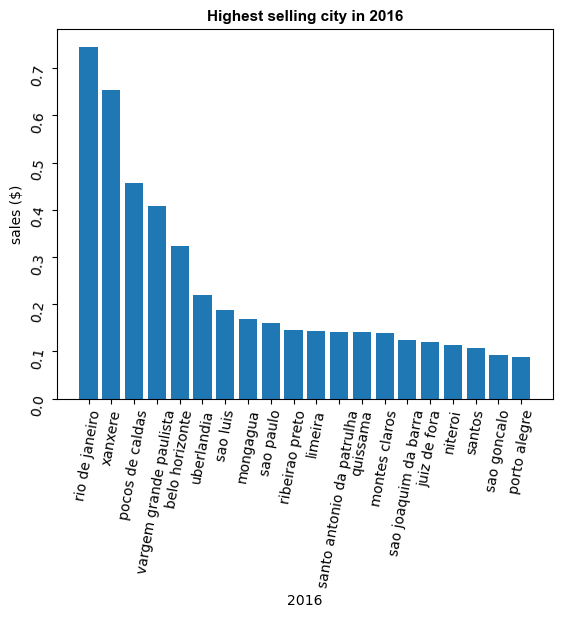

In [66]:
for yy in dt_main['YY'].unique():
    # Extract sales data
    dataPart1=dt_main[dt_main['YY']==yy]
    
    # calculate sales revenue
    dataPart1=dataPart1.groupby(dataPart1['customer_city']).agg({'price': 'sum'}).reset_index()
    dataPart1=dataPart1.sort_values(by=['price'], ascending=False)
    dataPart1=dataPart1.head(20)
    dataPart1['price']=dataPart1['price']/1000000
    
    # Display sales revenue
    print(dataPart1)    
    
    # show graph
    disp_graph(dataPart1,"customer_city","price",f"Highest selling city in {yy}")

### Question 3: Which highest selling state ?

   customer_state       price
21             RR    0.281085
2              AM    0.462656
0              AC    0.505468
3              AP    0.617097
20             RO    0.986219
24             SE    1.306232
19             RN    1.458031
26             TO    1.671334
16             PI    2.279232
1              AL    2.607338
14             PB    3.545418
11             MS    4.530643
5              CE    4.855754
9              MA    4.873588
13             PA    5.588978
6              DF    5.892311
15             PE    6.698679
8              GO    9.768682
12             MT   11.710852
7              ES   18.721831
4              BA   27.950239
23             SC   34.811845
17             PR   40.532348
22             RS   45.750757
18             RJ  127.141079
10             MG  176.042666
25             SP  314.859685


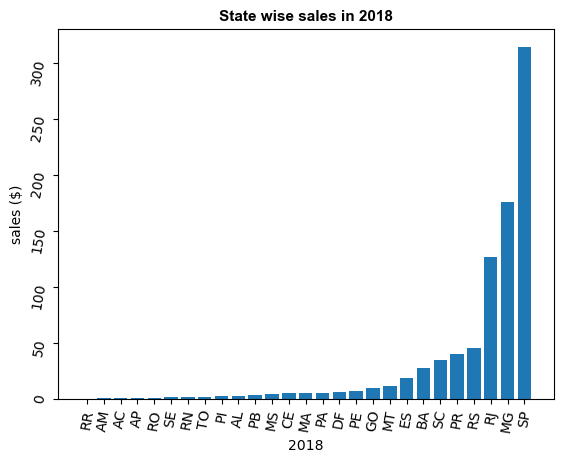

   customer_state       price
21             RR    0.041411
2              AM    0.301796
3              AP    0.324379
0              AC    0.677987
19             RN    1.326553
26             TO    1.344682
20             RO    1.380651
24             SE    1.657345
16             PI    1.764808
14             PB    2.182141
1              AL    2.188456
9              MA    3.364961
11             MS    3.499638
6              DF    4.022188
5              CE    4.069580
13             PA    6.123122
15             PE    6.142522
8              GO    8.286482
12             MT   11.919415
7              ES   12.688642
4              BA   23.437818
23             SC   28.572993
17             PR   31.692964
22             RS   46.130010
18             RJ  130.553790
10             MG  167.928344
25             SP  223.259815


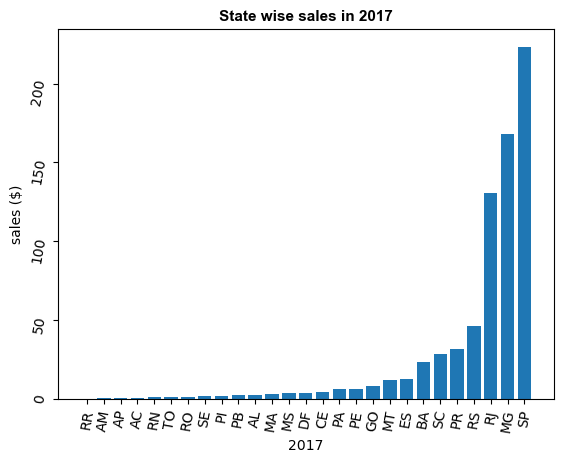

   customer_state     price
10             PB  0.000798
0              AL  0.001800
19             SE  0.007292
12             PI  0.008610
16             RR  0.010016
8              MT  0.027131
5              GO  0.030490
4              ES  0.032304
11             PE  0.034485
15             RN  0.040615
3              DF  0.051705
1              BA  0.053390
2              CE  0.076971
9              PA  0.083063
6              MA  0.208420
13             PR  0.260917
17             RS  0.444958
18             SC  0.787336
14             RJ  1.204839
7              MG  1.490376
20             SP  1.991090


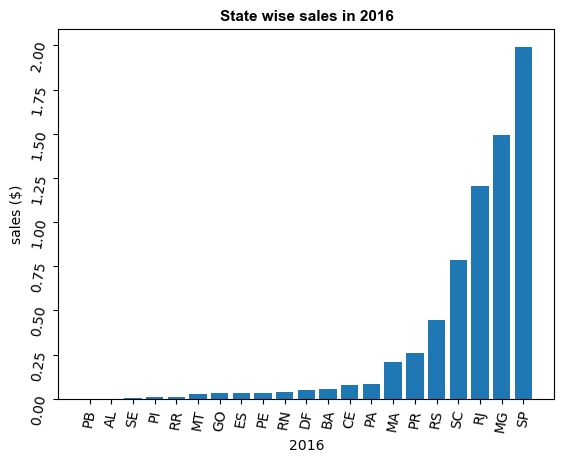

In [70]:
for yy in dt_main['YY'].unique():
    # extract yearly data
    dataPart1=dt_main[dt_main['YY']==yy]
    
    # calculate revenue
    dataPart1=dataPart1.groupby(dataPart1['customer_state']).agg({'price': 'sum'}).reset_index()
    dataPart1=dataPart1.sort_values(by=['price'])
    
    # To million
    dataPart1['price']=dataPart1['price']/1000000
    
    # show revenue
    print(dataPart1)
    
     # show graph
    disp_graph(dataPart1,"customer_state","price",f"State wise sales in {yy}")


### Question 4: Whic is the best year for the sales? How much earned ?

     YY      price
0  2016   0.684660
1  2017  72.488249
2  2018  85.545004


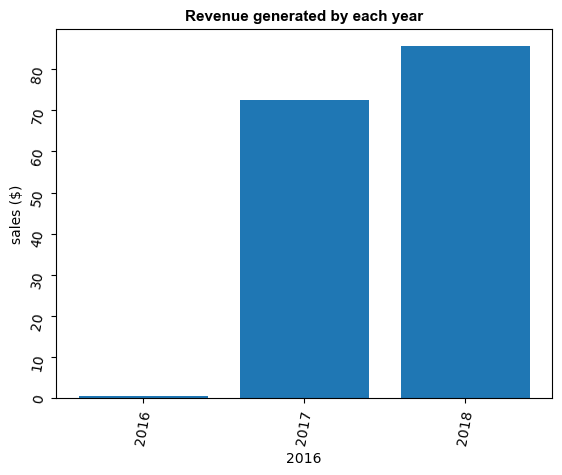

In [71]:
# Copy data
dataPart1=dt_main.copy()

# create revenue
dataPart1=dataPart1.groupby(dataPart1['YY']).agg({'price': 'sum'}).reset_index()
dataPart1=dataPart1.sort_values(by=['price'])

# To million
dataPart1['price']=dataPart1['price']/10000000
print(dataPart1)

 # show graph
disp_graph(dataPart1,"YY","price",f"Revenue generated by each year")


### Question 5:  Which is the best time of advertisement? Which is the best time of maintenance ?

In [72]:
# Copy data
dataPart1=dt_main.copy()

# calculate summary
dataPart1=dataPart1.groupby(dataPart1['Hour']).agg({'price': 'count'}).reset_index()

# to million
dataPart1['price']=dataPart1['price']/100000

# Display data
print(dataPart1)

    Hour     price
0      0   3.21715
1      1   1.58150
2      2   0.81376
3      3   0.38979
4      4   0.47216
5      5   0.22789
6      6   0.61702
7      7   1.68740
8      8   4.34435
9      9   7.26405
10    10   9.30075
11    11   9.82584
12    12   8.75442
13    13   9.07430
14    14  10.69500
15    15   9.67821
16    16   9.94880
17    17   9.72038
18    18   8.80228
19    19   8.46532
20    20   8.75875
21    21   8.31892
22    22   7.70331
23    23   5.71916


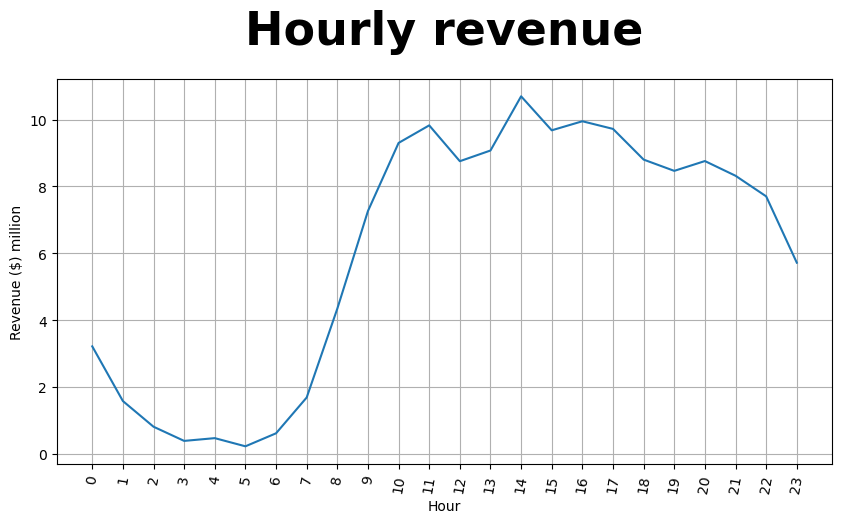

In [74]:
plt.figure(figsize=(10, 5)) 
plt.grid(True)
plt.plot(dataPart1['Hour'],dataPart1['price'])
plt.xlabel("Hour")
plt.ylabel('Revenue ($) million')
plt.xticks(dataPart1['Hour'])
plt.tick_params(axis='x', rotation=80)
plt.title(  "Hourly revenue",  weight="bold",fontsize=33, pad=25)
plt.show()

### Question 6:  Which is the highest product sold?

     product_category_name     price
13         cama_mesa_banho  15.49990
54        moveis_decoracao  14.53306
11            beleza_saude  10.98366
44  informatica_acessorios  10.74300
32           esporte_lazer  10.42672
72   utilidades_domesticas  10.40548
40      ferramentas_jardim   7.40847
66      relogios_presentes   6.37927
70               telefonia   4.82294
12              brinquedos   4.40174


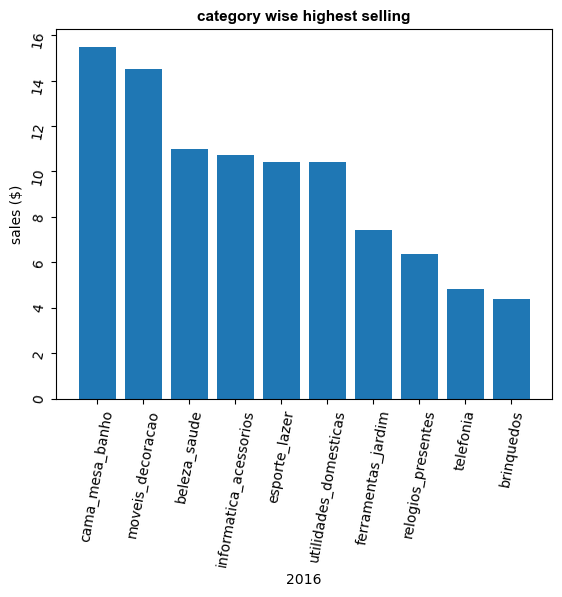

In [77]:
# copy data
dataPart1=dt_main.copy()

# calculate data summary 
dataPart1=dataPart1.groupby(dataPart1['product_category_name']).agg({'price': 'count'}).reset_index()
dataPart1['price']=dataPart1['price']/100000
dataPart1=dataPart1.sort_values(by=['price'], ascending=False)

# select top 10
dataPart1=dataPart1.head(10)

# display on the screen
print(dataPart1)


# show graph
disp_graph(dataPart1,"product_category_name","price",'category wise highest selling')

### Question 7:  Which is the highest product sold in each year?

     product_category_name      price
11            beleza_saude  80.481833
13         cama_mesa_banho  74.128930
66      relogios_presentes  68.063952
44  informatica_acessorios  66.865663
32           esporte_lazer  59.262605
54        moveis_decoracao  56.273265
71   utilidades_domesticas  49.844979
8               automotivo  32.423034
40      ferramentas_jardim  29.004444
9                    bebes  25.310308


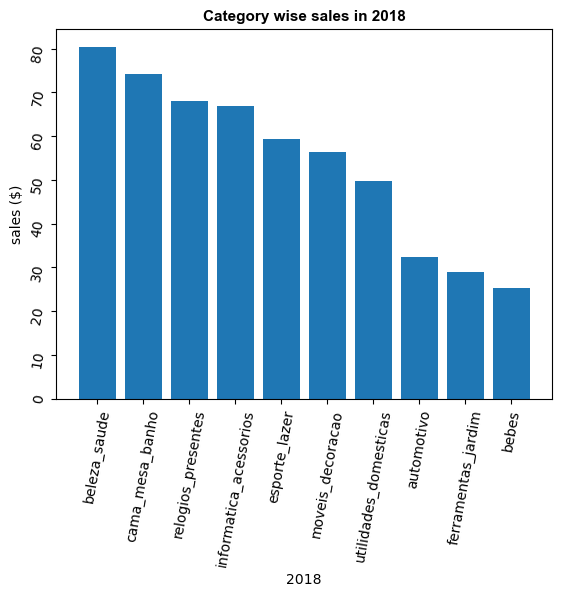

     product_category_name      price
13         cama_mesa_banho  70.746615
54        moveis_decoracao  54.986844
32           esporte_lazer  52.253519
44  informatica_acessorios  51.852324
11            beleza_saude  46.673998
65      relogios_presentes  46.357406
40      ferramentas_jardim  39.484385
26              cool_stuff  38.447163
12              brinquedos  31.446651
71   utilidades_domesticas  28.287868


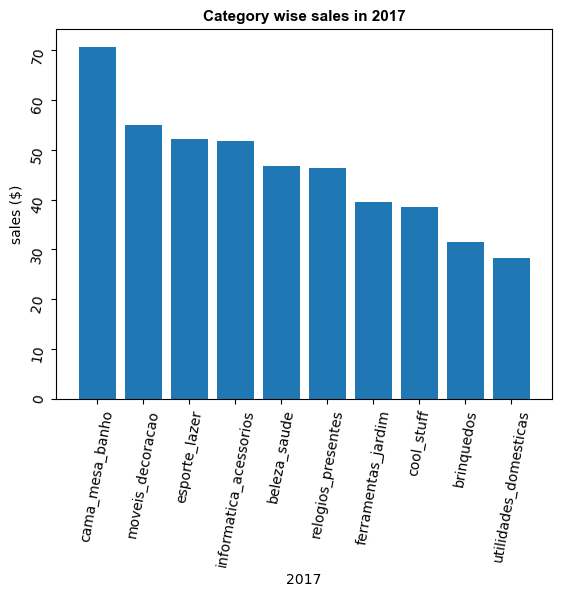

     product_category_name     price
7             climatizacao  0.889634
23        moveis_decoracao  0.863627
25              perfumaria  0.732990
4             beleza_saude  0.609630
5               brinquedos  0.457234
19  informatica_acessorios  0.424824
8           consoles_games  0.418295
10             eletronicos  0.412412
3                    bebes  0.326780
11           esporte_lazer  0.320186


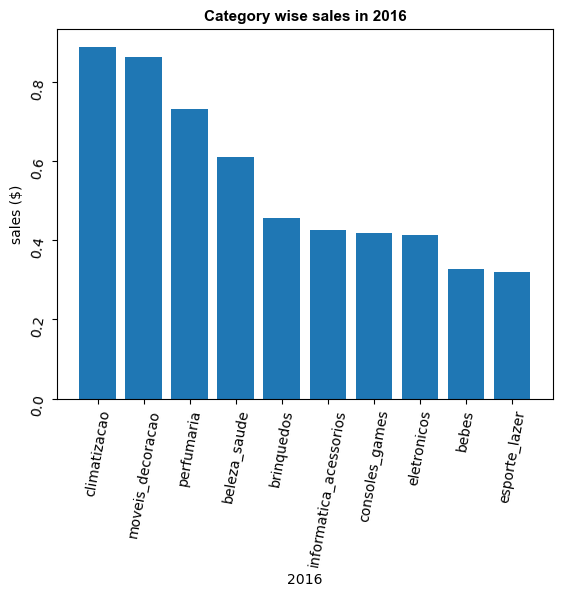

In [79]:
for yy in dt_main['YY'].unique():
    
    # Copy data 
    dataPart1=dt_main[dt_main['YY']==yy]
    
    # create summary 
    dataPart1=dataPart1.groupby(dataPart1['product_category_name']).agg({'price': 'sum'}).reset_index()
    
    # sort sample
    dataPart1=dataPart1.sort_values(by=['price'], ascending=False)
    
    # select top 10 records
    dataPart1=dataPart1.head(10)
    
    # to million
    dataPart1['price']=dataPart1['price']/1000000
    
    # print on the screen
    print(dataPart1)
    
    # show graph
    disp_graph(dataPart1,"product_category_name","price",f"Category wise sales in {yy}" )

### Question 7:  resolve website not available issue

    Hour  order_id  priorder_idce
23    23    571916        5.71916
22    22    770331        7.70331
21    21    831892        8.31892
20    20    875875        8.75875
19    19    846532        8.46532
18    18    880228        8.80228
17    17    972038        9.72038
16    16    994880        9.94880
15    15    967821        9.67821
14    14   1069500       10.69500
13    13    907430        9.07430
12    12    875442        8.75442
11    11    982584        9.82584
10    10    930075        9.30075
9      9    726405        7.26405
8      8    434435        4.34435
7      7    168740        1.68740
6      6     61702        0.61702
5      5     22789        0.22789
4      4     47216        0.47216
3      3     38979        0.38979
2      2     81376        0.81376
1      1    158150        1.58150
0      0    321715        3.21715


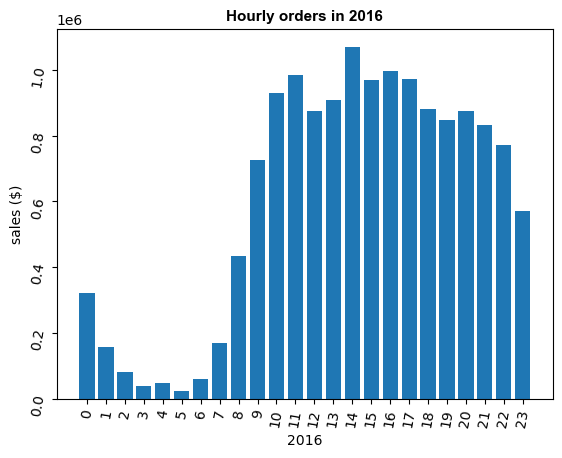

In [80]:
# Copy data 
dataPart1=dt_main.copy()

# create summary 
dataPart1=dataPart1.groupby(dataPart1['Hour']).agg({'order_id': 'count'}).reset_index()

# sort sample
dataPart1=dataPart1.sort_values(by=['Hour'], ascending=False)


# select top 10 records
dataPart1['priorder_idce']=dataPart1['order_id']/100000

# print on the screen
print(dataPart1)

# show graph
disp_graph(dataPart1,"Hour","order_id",f"Hourly orders in {yy}")

### 3) Recommondation the best product 

In [81]:
# filter product with the highest review
dataPart1 = dt_main[dt_main['review_score']>=3][["order_id","review_score","review_comment_title","review_comment_message","review_creation_date"]]

In [82]:
dataPart1

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date
0,53cdb2fc8bc7dce0b6741e2150273451,5,NaN,NaN,2017-12-19 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,5,NaN,NaN,2017-12-19 00:00:00
2,53cdb2fc8bc7dce0b6741e2150273451,5,NaN,NaN,2017-12-19 00:00:00
3,53cdb2fc8bc7dce0b6741e2150273451,5,NaN,NaN,2017-12-19 00:00:00
4,53cdb2fc8bc7dce0b6741e2150273451,5,NaN,NaN,2017-12-19 00:00:00
...,...,...,...,...,...
21308751,ada8de3a9486cea2fce7f4b00319cf3c,5,NaN,Muito bom....,2018-05-11 00:00:00
21308752,ada8de3a9486cea2fce7f4b00319cf3c,5,NaN,Muito bom....,2018-05-11 00:00:00
21308753,ada8de3a9486cea2fce7f4b00319cf3c,5,NaN,Muito bom....,2018-05-11 00:00:00
21308754,ada8de3a9486cea2fce7f4b00319cf3c,5,NaN,Muito bom....,2018-05-11 00:00:00


5    8406720
4    2796424
3    1206538
Name: review_score, dtype: int64


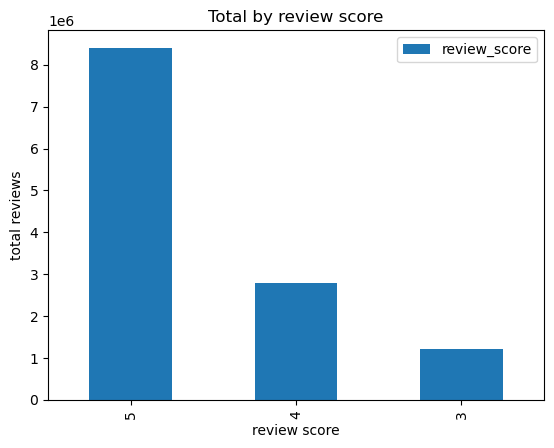

In [84]:
# display bar graph
gdata=pd.value_counts(dataPart1['review_score'])
print(gdata)
gdata.plot.bar()
plt.title('Total by review score')
plt.xlabel("review score")
plt.ylabel('total reviews')

plt.legend()

### Collabrative filtering


In [98]:
# filter product with the highest review
dataPart1 = dt_main[dt_main['customer_city']=="rio de janeiro"][["product_id","customer_id","order_id","review_score","review_comment_title","review_comment_message","review_creation_date"]]

dataPart1 = dataPart1[dataPart1['review_score']>=3 ]

# Select sample data of 20000 ratings
dataPart1=dataPart1.iloc[:20000,0:]

In [99]:
dataPart1

,product_id,customer_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date
323,595fac2a385ac33a80bd5114aec74eb8,67407057a7d5ee17d1cd09523f484d13,40c5e18f7d112b59b3e5113a59a905b3,4,NaN,NaN,2017-10-14 00:00:00
324,595fac2a385ac33a80bd5114aec74eb8,67407057a7d5ee17d1cd09523f484d13,40c5e18f7d112b59b3e5113a59a905b3,4,NaN,NaN,2017-10-14 00:00:00
325,595fac2a385ac33a80bd5114aec74eb8,67407057a7d5ee17d1cd09523f484d13,40c5e18f7d112b59b3e5113a59a905b3,4,NaN,NaN,2017-10-14 00:00:00
326,595fac2a385ac33a80bd5114aec74eb8,67407057a7d5ee17d1cd09523f484d13,40c5e18f7d112b59b3e5113a59a905b3,4,NaN,NaN,2017-10-14 00:00:00
327,595fac2a385ac33a80bd5114aec74eb8,67407057a7d5ee17d1cd09523f484d13,40c5e18f7d112b59b3e5113a59a905b3,4,NaN,NaN,2017-10-14 00:00:00
...,...,...,...,...,...,...,...
194575,0f91b6a95a57a43203a9b17de98960d9,69ee62ecc8d2937fca0e1a3d4de5a2ce,c6094f6ab0c25eda761622ab09aa423d,5,NaN,NaN,2018-07-22 00:00:00
194576,0f91b6a95a57a43203a9b17de98960d9,69ee62ecc8d2937fca0e1a3d4de5a2ce,c6094f6ab0c25eda761622ab09aa423d,5,NaN,NaN,2018-07-22 00:00:00
194577,0f91b6a95a57a43203a9b17de98960d9,69ee62ecc8d2937fca0e1a3d4de5a2ce,c6094f6ab0c25eda761622ab09aa423d,5,NaN,NaN,2018-07-22 00:00:00
194578,0f91b6a95a57a43203a9b17de98960d9,69ee62ecc8d2937fca0e1a3d4de5a2ce,c6094f6ab0c25eda761622ab09aa423d,5,NaN,NaN,2018-07-22 00:00:00


In [100]:
# create rating pivot table
r = dataPart1.pivot_table( columns='product_id', values='review_score',index='customer_id', fill_value=0)
r = r.T
print('Total records: ', r)

Total records:  customer_id                       011fc4ea8b9a1e857358c71da7dcf852  \
product_id                                                           
01b864cf36d60d972e2e29d8c5084d64                               0.0   
052413504e5295cd66ec4ced0b310062                               0.0   
07c055536ebf10dfbb6c6db6dbfc36e5                               0.0   
0b48dc720b9a40d75ce14eda10be0922                               0.0   
0b814a3c8fa6dbb849df7c28c1bd6831                               0.0   
...                                                            ...   
f989412e4e7110deab61cdc486f8e0de                               0.0   
f9e5efb845b51d764b06f149eb99fc7f                               0.0   
fa9cc1dfd86d0877d43101973bf26eee                               0.0   
fbc1488c1a1e72ba175f53ab29a248e8                               0.0   
fe6a9515d655fa7936b8a7c841039f34                               0.0   

customer_id                       017af68734338e58b5925665038650ed  \
pro

In [102]:
# matrix decomposition and transformation
SVD = TruncatedSVD(n_components=10)
m = SVD.fit_transform(r)
print(m)

[[ 5.02418242e-05  1.17642590e-03  1.06933939e-03 ... -3.15772770e-02
   4.82330317e-01  4.71539287e-01]
 [ 4.20828766e-06 -6.20873837e-04 -3.95648402e-04 ...  6.07101564e-05
   1.17612845e-02  2.23316803e-02]
 [-3.43755104e-05 -5.15260031e-03  3.05637392e+00 ...  7.43337151e-03
   1.49067806e-02 -1.57206423e-02]
 ...
 [-7.14360703e-05  8.60006448e-03  3.40797484e-02 ... -7.87478247e-02
  -1.84533551e-01  2.51389009e-01]
 [-2.02856336e-04 -4.80168421e-03 -1.95040113e-02 ...  2.72422151e-02
  -7.03454357e-02 -3.50242557e-01]
 [-8.12140717e-06 -1.23613528e-02 -3.10984945e-02 ...  5.33952594e-02
  -2.53748357e-02 -2.98632932e-02]]


In [103]:
# calcualate correlation coefficient
final_crm_matrix = np.corrcoef(m)

In [114]:
def find_suitable_product(index):
    
    # display selected product
    productId=r.index[index]
    print('Customer view/select/add to card:',productId)


    # select item with highest relation
    items = list(r.index[final_crm_matrix[index] > 0.90])
    
    # return the list
    return items[0:10]

In [119]:
# Show recommended products
find_suitable_product(20)

Customer view/select/add to card: 2f13d1dc8b4e1d9d8027be50339546a9


['01b864cf36d60d972e2e29d8c5084d64',
 '052413504e5295cd66ec4ced0b310062',
 '0c761b0e33d708e6a3694a94ac4b82c4',
 '2bfc998cf625e54b2c6447bfc7c18cb4',
 '2f13d1dc8b4e1d9d8027be50339546a9',
 '43fe236fd16fba129a5498ba4b1b47fe',
 '70c325280f670aee445babb3400cf804',
 '722dc14e0848efdb771dca6de2929c41',
 '84f5c4f480ad6c9998d6a6860f1a2e41',
 '97df437aeb3472b9d42b4c2e9a9d88f6']

In [120]:
# Show recommended products
find_suitable_product(1)

Customer view/select/add to card: 052413504e5295cd66ec4ced0b310062


['01b864cf36d60d972e2e29d8c5084d64',
 '052413504e5295cd66ec4ced0b310062',
 '0c761b0e33d708e6a3694a94ac4b82c4',
 '2bfc998cf625e54b2c6447bfc7c18cb4',
 '2f13d1dc8b4e1d9d8027be50339546a9',
 '43fe236fd16fba129a5498ba4b1b47fe',
 '722dc14e0848efdb771dca6de2929c41',
 '84f5c4f480ad6c9998d6a6860f1a2e41',
 '97df437aeb3472b9d42b4c2e9a9d88f6',
 '9e9289854d376ff8dc6d8200e4d1d754']

In [121]:
# Show recommended products
find_suitable_product(12)

Customer view/select/add to card: 1e618d311a1b7f88a9d96ec50aa85582


['13944d17b257432717fd260e69853140',
 '1a0bba83632b7dc923d939a7fa2c4530',
 '1e618d311a1b7f88a9d96ec50aa85582',
 '3dd2a17168ec895c781a9191c1e95ad7',
 '50fd2b788dc166edd20512370dac54df',
 'a11b92613ac1f37b3617b440c7b9e6b3',
 'c8e7965a98acecf61c4cebbaf5c08c53']

In [122]:
# Show recommended products
find_suitable_product(13)

Customer view/select/add to card: 2136c70bbe723d338fab53da3c03e6dc


['2136c70bbe723d338fab53da3c03e6dc', 'd1c427060a0f73f6b889a5c7c61f2ac4']